<a href="https://colab.research.google.com/github/ameasure/colab_tutorials/blob/master/Introduction_to_Deep_Learning_and_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

# Deep Learning and Neural Networks

Deep learning is a subfield of machine learning that seeks to solve problems by learning intermediate data representations. The primary algorithm for deep learning is the deep neural network, and if you've been following developments in Artificial Intelligence over the last decade you have probably heard a lot about them. Among its many recent accomplishments, deep learning techniques are now directly responsible the recent and very dramatic advances in image recognition, speech recognition, and language understanding.

Unfortunately, as you will soon see, deep neural networks also much more difficult to build than the models we have seen so far in class. Among the many challenges:
1) Deep neural networks often require extraordinary amounts of computation
2) Effective training of deep neural networks often relies on a wide variety of poorly understood heuristics
3) Deep neural networks tends to have a much larger number of hyperparameters requiring expert tuning

We can only partially address the first problem in this class. Specifically, BLS now has a small number of high-end GPU's (Graphical Processing Units). A GPU is basically a very cheap super-computer, optimized for linear algebra operations. Each contains several thousand simple computers with ultra-fast memory interfaces between them so they can rapidly exchange and aggregate information. Even if you had the budget for it, you could not replicate this performance with thousands of traditional computer processing units. 

We will be using these GPU's for our experiments. If you wish to train deep neural networks outside of BLS, Google makes free GPU's available through [Google Colab](https://colab.research.google.com/). GPU's are also relatively affordable, a good buying guide for deep learning applications is available [here](https://blog.slavv.com/picking-a-gpu-for-deep-learning-3d4795c273b9). You are also free to try training neural networks without GPU acceleration, but be warned, unless you are building something very simple, you will be waiting a long time.

One consequence of the deep neural networks' exotic hardware needs is that we will also need new software capable of using that hardware. We will use the `tensorflow` library, which is the most popular tool for training deep neural networks. We will also be using the `keras` library, which is a simplified interface on top of tensorflow. A reasonable alternative is the `PyTorch` library, but we will not cover that in this class.

# What is a deep neural network?

A deep neural network is just an extension of logistic regression, which itself is just an extension of linear regression. Recall the basic equation for a simple linear regression. If the inputs are represented by the variables $x_1, x_2, ..., x_i$, and the weights controlling the influence of these inputs is represented by $w_1, w_2, ..., w_i$ then the equation for linear regression is:

$y=w_1x_1 + w_2x_2 + ... + w_ix_i$

As we saw in logistic regression, we can modify this one step further, by passing the entire output through the logistic function $f(z)=\frac{1}{1+e^{-z}}$. This has the effect of contraining the output to be between 0 and 1. Our equation now becomes:

$y=f(w_1x_1 + w_2x_2 + ... + w_ix_i)$

If we draw this in graphical form, with three inputs, it resembles the following:
![logistic regression](https://github.com/ameasure/colab_tutorials/blob/master/Images/artificial%20neuron.png?raw=1)

From this perspective, logistic regression shares some similarities with the biological neuron. Like a biological neuron, logistic regression receives inputs from a variety of sources. Like a biological neuron, the influence of these inputs seems to be controlled by the strengths of the connections (represented by weights, in logistic regression). And like a biological neuron, the logistic regression uses this information to produce an output. Hence, an alternate interpretation of logistic regression, the artificial neuron. In neural network speak, this neuron has 4 key components:
* three inputs ($x_1, x_2, x_3$)
* three weights ($w_1, w_2, w_3$)
* an acitivation function ($f(w,x)$, in this case the `logistic` function)
* an output (a.k.a. activation) ($y$)

Logistic regression does not, of course, acquire any magical new powers by simply changing its name. But interesting things start to happen as we extend our metaphor. What happens when we start connecting these artificial neurons to other artificial neurons, i.e. using the outputs of some neurons and inputs to others? 

Although we can connect our neural networks in all sorts of patterns, for computational convenience it is common to organize our artificial neurons into layers, and design our neural network by describing how our various layers connect to each other.

This might sound exotic, but in fact we have already worked with a layer of artificial neurons, we just didn't know it. A single layer of artificial neurons in which each neuron is connected to all inputs and each uses the multinomial logistic function is exactly equivalent to the multinomial logistic regression we have used so extensively in this class. We will soon see however, that by connecting these layers to other layers, we can address a wide variety of issues we struggled with before. One thing that does not change however, is the fundamental process by which we calculate the weights of our artificial neural network. We still use gradient descent, specifically the following algorithm:
1. Randomly initialize the weights of our neurons to small values.
2. Choose a loss function (some measure of how poorly our model is predicting the training data)
3. Calculate the model's loss on the training data
4. Update the weights in the direction that reduces loss (using calculus)
5. Repeat steps 3 and 4 until we're happy with the network's performance


# Feed Forward Neural Network
Enough talk, lets start by building one of the simplest possible neural networks, a feed forward neural network with 1 hidden layer and 1 output layer. Visually, this resembles the following (but with more neurons in each layer).

![neural_network](https://github.com/ameasure/colab_tutorials/blob/master/Images/feed_forward_network_wikipedia_300px.png?raw=1)

# Note for Colab Users: 
If you're running this in Google Colab make sure you open up the **Runtime** tab, select **Change runtime type** and select **GPU** as the hardware accelerator. This will make the following computations run much faster. You will also need to execute the following command to copy the msha data to your Colab instance.

In [2]:
!wget --no-clobber 'https://github.com/ameasure/autocoding-class/raw/master/msha.xlsx'

--2019-06-21 19:55:00--  https://github.com/ameasure/autocoding-class/raw/master/msha.xlsx
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ameasure/autocoding-class/master/msha.xlsx [following]
--2019-06-21 19:55:01--  https://raw.githubusercontent.com/ameasure/autocoding-class/master/msha.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4183086 (4.0M) [application/octet-stream]
Saving to: ‘msha.xlsx’

msha.xlsx           100%[===================>]   3.99M  --.-KB/s    in 0.09s   

2019-06-21 19:55:01 (46.7 MB/s) - ‘msha.xlsx’ saved [4183086/4183086]



### Preparing the data
We'll use our msha data to train our first neural network. The process of preparing the training data is mostly similar to the process we used for scikit-learn, with one key difference. Unlike scikit-learn, Keras requires the outputs (the y-values) to be in matrix format where each row corresponds to a training example, each column corresponds to a part-of-body-code, and the column containing the correct code has a value of 1 and the others have a value of 0. Scikit-learn constructed this matrix for us behind the scenes automatically. We can easily perform the same operation for Keras using scikit-learn's LabelBinarizer.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer

import pandas as pd

# read in the data and split it into training and validation
df = pd.read_excel('msha.xlsx')
df['ACCIDENT_YEAR'] = df['ACCIDENT_DT'].apply(lambda x: x.year)
df['ACCIDENT_YEAR'].value_counts()
df_train = df[df['ACCIDENT_YEAR'].isin([2010, 2011])].copy()
df_valid = df[df['ACCIDENT_YEAR'] == 2012].copy()
print('training rows:', len(df_train))
print('validation rows:', len(df_valid))

# create bag of words features
vectorizer = CountVectorizer()
vectorizer.fit(df_train['NARRATIVE'])
X_train = vectorizer.transform(df_train['NARRATIVE'])
X_valid = vectorizer.transform(df_valid['NARRATIVE'])

# keras only accepts a one-hot encoding of the training labels
# we do that here
label_encoder = LabelBinarizer().fit(df_train['INJ_BODY_PART'])
y_train = label_encoder.transform(df_train['INJ_BODY_PART'])
y_valid = label_encoder.transform(df_valid['INJ_BODY_PART'])
n_codes = len(label_encoder.classes_)

training rows: 18681
validation rows: 9032


In [26]:
print(X_train.shape)
print(y_train.shape)
print(y_train[0])

(18681, 11915)
(18681, 46)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0]


Define the organization of our neural network

In [0]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam

# First, we create an input layer. This tells keras
# what the input data will look like. Specifically, that
# the input will contain the same number of columns
# as the X_train matrix (i.e. the number of features)
text_input = Input(shape=(X_train.shape[1],))
# Next, we create the first hidden layer. 
# Dense means every neuron in this layer is connected to every input
# units specifies the number of artificial neurons in this layer
# activation indicates the activation function that will be used on each neuron
# (text_input) indicates that the layer uses output of the text_input layer as its input
layer1 = Dense(units=100, activation='relu')(text_input)
# Now we specify the ouput layer
# it contains one neuron for each part of body code (we want predctions for these)
# each neuron uses the softmax activation so that the outputs mimic probabilities
# Note: this is identical to a multinomial logistic regression model
output = Dense(units=n_codes, activation='softmax')(layer1)

# Finally, we tell Keras which layers are the inputs and outputs of our model
model = Model(inputs=[text_input], outputs=[output])

# We then tell Keras how we plan to fit the model
# optimizer - specifies the algorithm we will use to update the model weights
#   specifically, we use a variant of gradient descent called Adam
#   with a learning rate of .001
# loss - specifices the loss function we will use when updating weights
# metrics - specifies the validation metrics we will calculate after each epoch
optimizer = Adam(lr=.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Examine the model.

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 11915)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               1191600   
_________________________________________________________________
dense_20 (Dense)             (None, 46)                4646      
Total params: 1,196,246
Trainable params: 1,196,246
Non-trainable params: 0
_________________________________________________________________


Now that we have specified our model, we can fit it to our data.

In [29]:
# x - the training input to our model
# y - the training ouput for our model
# batch_size - the number of training examples we use for each gradient update
# epochs - the number of full cycles through the training data
# validation_data - the data we evaluate the model on at the end of each epoch
model.fit(x=X_train, y=y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32, epochs=5)

Train on 18681 samples, validate on 9032 samples
Epoch 1/5
18681/18681 [==============================] - 4s 236us/step - loss: 1.6982 - acc: 0.6177 - val_loss: 1.0206 - val_acc: 0.7525
Epoch 2/5
18681/18681 [==============================] - 4s 206us/step - loss: 0.7213 - acc: 0.8214 - val_loss: 0.8953 - val_acc: 0.7618
Epoch 3/5
18681/18681 [==============================] - 4s 201us/step - loss: 0.4435 - acc: 0.8887 - val_loss: 0.9015 - val_acc: 0.7601
Epoch 4/5
18681/18681 [==============================] - 4s 203us/step - loss: 0.2946 - acc: 0.9297 - val_loss: 0.9494 - val_acc: 0.7575
Epoch 5/5
18681/18681 [==============================] - 4s 206us/step - loss: 0.2048 - acc: 0.9531 - val_loss: 1.0083 - val_acc: 0.7482


What's going on? It's just gradient descent, the same algorithm we used to calculate the parameters of our models before. The main difference is that Keras is now showing us lots of intermediate outputs. In particular, you can see how the loss of the model changes as we grab a new batch of training examples, calculate the loss, and then update the weights. When we get to the end of each epoch you see Keras calculate the accuracy of the model on the validation data set. We do this so we know when to stop training our model, i.e. when the validation performance starts going down it's time to stop because our model is overfitting to the training data. We can plot the pattern below.

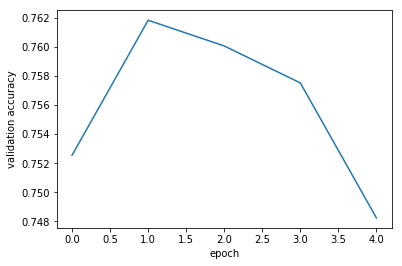

In [30]:
from matplotlib import pyplot as plt

plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.plot(model.history.history['val_acc'])

This is a popular technique for determining how long to train neural networks because neural networks tend to be heavily over-parameterized, if you train them for long enough they can pften overfit the training data very easily.

# Using the Model
As with scikit-learn models, we can generate the predictions and save them to a dataframe.

In [31]:
# get the [n_cases, n_classes] predicted probability matrix
prediction_prob_matrix = model.predict(X_valid)
# get the classes with the highest predicted probability, save them to our dataframe
df_valid['PREDICTED_PART'] = label_encoder.inverse_transform(prediction_prob_matrix)
# add the predicted probabilities
df_valid['PREDICTED_PROB'] = prediction_prob_matrix.max(axis=1)
# take a look at what we've got
df_valid.head()

,ACCIDENT_DT,FIPS_STATE_CD,INJ_BODY_PART,INJ_BODY_PART_CD,MINE_ID,NARRATIVE,ACCIDENT_YEAR,PREDICTED_PART,PREDICTED_PROB
2,2012-08-20,24,HIPS (PELVIS/ORGANS/KIDNEYS/BUTTOCKS),440,1800761,"Employee, parked s/c on grade at 16-Block #3 E...",2012,BACK (MUSCLES/SPINE/S-CORD/TAILBONE),0.472066
5,2012-02-21,42,BODY SYSTEMS,600,3600017,Possible heart attack.,2012,BODY SYSTEMS,0.479466
8,2012-10-03,41,SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA),450,3503757,Employee was cleaning up plant spillage into a...,2012,BACK (MUSCLES/SPINE/S-CORD/TAILBONE),0.537666
12,2012-01-23,17,FINGER(S)/THUMB,340,1103189,"Employee was putting a drag on a shuttle car, ...",2012,FINGER(S)/THUMB,0.999997
27,2012-05-10,42,HAND (NOT WRIST OR FINGERS),330,4600016,While using a cutting torch to remove a bearin...,2012,HAND (NOT WRIST OR FINGERS),0.913539


# Regularization

Even more so than linear models, neural networks suffer from overfitting. Because they have such a large number of parameters they can easily memorize the data they are trained on. We can use L2-regularization, as we did with our logistic regression models, but for neural networks another popular technique is called `dropout`. In dropout we randomly set the outputs of a fraction of neurons, at each training step, to 0. A popular choice is 50%. This has a strong regularization effect that often improves overall performance. Let's try it out.

In [33]:
text_input = Input(shape=(X_train.shape[1],))
layer1 = Dense(units=100, activation='relu')(text_input)
dropout = Dropout(0.5)(layer1)
output = Dense(units=len(label_encoder.classes_), activation='softmax')(dropout)
# specify the inputs and outputs of our model
# input is the raw text features
# output is the predicted probabilities
do_model = Model(inputs=[text_input], outputs=[output])
# specify the algorithm for calculating weights 'adam'
# specify the loss function 'categorical_crossentropy'
# specify the validation metrics we will calculate after each epoch
optimizer = Adam(lr=.001)
do_model.compile(optimizer=optimizer, 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

do_model.fit(x=X_train, y=y_train,
            validation_data=(X_valid, y_valid),
            batch_size=32, epochs=5)

Train on 18681 samples, validate on 9032 samples
Epoch 1/5
18681/18681 [==============================] - 5s 251us/step - loss: 2.0095 - acc: 0.5374 - val_loss: 1.1839 - val_acc: 0.7273
Epoch 2/5
18681/18681 [==============================] - 4s 214us/step - loss: 1.0570 - acc: 0.7455 - val_loss: 0.9258 - val_acc: 0.7683
Epoch 3/5
18681/18681 [==============================] - 4s 214us/step - loss: 0.7745 - acc: 0.8032 - val_loss: 0.8588 - val_acc: 0.7723
Epoch 4/5
18681/18681 [==============================] - 4s 213us/step - loss: 0.6129 - acc: 0.8421 - val_loss: 0.8515 - val_acc: 0.7706
Epoch 5/5
18681/18681 [==============================] - 4s 213us/step - loss: 0.5014 - acc: 0.8700 - val_loss: 0.8540 - val_acc: 0.7721


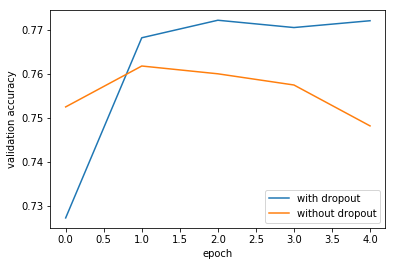

In [34]:
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.plot(do_model.history.history['val_acc'], label='with dropout')
plt.plot(model.history.history['val_acc'], label='without dropout')
plt.legend()

As you can see, adding dropout improved the overall performance of our model and decreased overfitting.

# Uncertainty Estimates and "Bayesian Neural Networks"
Our model already us estimates of uncertainty about classifications in the form of probability values, but can it also give us estimates of uncertainty in its probability predictions? [Yarin Gal and collaborators](https://arxiv.org/pdf/1506.02142.pdf) show that it can because training a neural network with dropout is equivalent to approximate Bayesian inference in a deep Gaussian process. To estimate the uncertainty of these predictions all we need to do is sample from the distribution by leaving dropout on while generating predictions. We illustrate this below:

In [0]:
import numpy as np

# turn training mode on in our dropout layer
dropout.training = True
# reassemble the model
do_model = Model(inputs=[text_input], outputs=[output])


# sample predictions from our model
y_probas = np.stack([do_model.predict(X_valid) for sample in range(100)])
# recover the "best predictions" by averaging over the predicted probabilities
y_prob = y_probas.mean(axis=0)
# we can also recover the standard deviations
y_std = y_probas.std(axis=0)

In [50]:
df_valid['BAYES_PRED'] = label_encoder.inverse_transform(y_prob)
df_valid['BAYES_PROB'] = y_prob.max(axis=1)
df_valid[['PREDICTED_PART', 'PREDICTED_PROB', 'BAYES_PRED', 'BAYES_PROB']].sample(10)

,PREDICTED_PART,PREDICTED_PROB,BAYES_PRED,BAYES_PROB
4490,HAND (NOT WRIST OR FINGERS),0.813552,HAND (NOT WRIST OR FINGERS),0.787618
38504,SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA),0.988725,SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA),0.991683
30755,BACK (MUSCLES/SPINE/S-CORD/TAILBONE),0.923062,BACK (MUSCLES/SPINE/S-CORD/TAILBONE),0.714240
32691,FOOT(NOT ANKLE/TOE)/TARSUS/METATARSUS,0.295573,BODY SYSTEMS,0.168635
9935,KNEE/PATELLA,0.971161,KNEE/PATELLA,0.939054
27804,HAND (NOT WRIST OR FINGERS),0.720019,HAND (NOT WRIST OR FINGERS),0.413574
18404,FINGER(S)/THUMB,0.999758,FINGER(S)/THUMB,0.998149
13665,MOUTH/LIP/TEETH/TONGUE/THROAT/TASTE,0.674352,MOUTH/LIP/TEETH/TONGUE/THROAT/TASTE,0.738358
14023,THIGH/FEMUR,0.981668,THIGH/FEMUR,0.702443
18097,MULTIPLE PARTS (MORE THAN ONE MAJOR),0.607771,MULTIPLE PARTS (MORE THAN ONE MAJOR),0.459034


In [54]:
from sklearn.metrics import accuracy_score, f1_score

bayes_acc = accuracy_score(df_valid['INJ_BODY_PART'], df_valid['BAYES_PRED'])
normal_acc = accuracy_score(df_valid['INJ_BODY_PART'], df_valid['PREDICTED_PART'])
bayes_mf1 = f1_score(df_valid['INJ_BODY_PART'], df_valid['BAYES_PRED'], average='macro')
normal_mf1 = f1_score(df_valid['INJ_BODY_PART'], df_valid['PREDICTED_PART'], average='macro')
print(f'orig acc: {normal_acc:.3f}')
print(f'bayes acc: {bayes_acc:.3f}')
print(f'orig macro f1: {normal_mf1:.3f}')
print(f'bayes macro f1: {bayes_mf1:.3f}')

orig acc: 0.748
bayes acc: 0.772
orig macro f1: 0.541
bayes macro f1: 0.547


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# When and why do deep neural networks work?
It's still a mystery, but hints are starting to emerge. For example, [[1]](https://arxiv.org/pdf/1608.08225.pdf) points out that hierarchical and compositional relationships are very common in nature and deep neural networks can represent these relationships with exponentially fewer parameters than shallow networks (linear models). It can also be shown that neural networks are universal function approximators, in other words they can approximate any relationship between inputs and outputs to any degree of precision. 

In general, deep neural networks seem to work best on tasks where the input contains large amounts of extraneous noise, such as image and speech understanding (not math or logic). 

# Next Lesson

[Convolutional Neural Networks](https://colab.research.google.com/drive/1Bck3x0znv61uDSkZIT5pAdO_oyWaUPup)